In [1]:
# Necessary imports for this notebook
import os

import numpy as np
import pandas as pd

import datetime
import time

import random

# For plotting
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Helper Functions

In [7]:
def generate_customer_profiles_table(n_customers, random_state=0):
    
    np.random.seed(random_state)
        
    customer_id_properties=[]
    
    # Generate customer properties from random distributions 
    for customer_id in range(n_customers):
        
        x_customer_id = np.random.uniform(0,100)
        y_customer_id = np.random.uniform(0,100)
        
        mean_amount = np.random.uniform(5,100) # Arbitrary (but sensible) value 
        std_amount = mean_amount/2 # Arbitrary (but sensible) value
        
        mean_nb_tx_per_day = np.random.uniform(0,4) # Arbitrary (but sensible) value 
        
        customer_id_properties.append([customer_id,
                                      x_customer_id, y_customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])
        
    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID',
                                                                      'x_customer_id', 'y_customer_id',
                                                                      'mean_amount', 'std_amount',
                                                                      'mean_nb_tx_per_day'])
    
    return customer_profiles_table

In [8]:
def generate_terminal_profiles_table(n_terminals, random_state=0):
    
    np.random.seed(random_state)
        
    terminal_id_properties=[]
    
    # Generate terminal properties from random distributions 
    for terminal_id in range(n_terminals):
        
        x_terminal_id = np.random.uniform(0,100)
        y_terminal_id = np.random.uniform(0,100)
        
        terminal_id_properties.append([terminal_id,
                                      x_terminal_id, y_terminal_id])
                                       
    terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=['TERMINAL_ID',
                                                                      'x_terminal_id', 'y_terminal_id'])
    
    return terminal_profiles_table

In [9]:
def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):
    
    # Use numpy arrays in the following to speed up computations
    
    # Location (x,y) of customer as numpy array
    x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float)
    
    # Squared difference in coordinates between customer and terminal locations
    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)
    
    # Sum along rows and compute suared root to get distance
    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))
    
    # Get the indices of terminals which are at a distance less than r
    available_terminals = list(np.where(dist_x_y<r)[0])
    
    # Return the list of terminal IDs
    return available_terminals

In [10]:
def generate_transactions_table(customer_profile, start_date = "2025-12-02", nb_days = 10):
    
    customer_transactions = []
    
    random.seed(int(customer_profile.CUSTOMER_ID))
    np.random.seed(int(customer_profile.CUSTOMER_ID))
    
    # For all days
    for day in range(nb_days):
        
        # Random number of transactions for that day 
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
        
        # If nb_tx positive, let us generate transactions
        if nb_tx>0:
            
            for tx in range(nb_tx):
                
                # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that 
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))
                
                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):
                    
                    # Amount is drawn from a normal distribution  
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    
                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)
                    
                    amount=np.round(amount,decimals=2)
                    
                    if len(customer_profile.available_terminals)>0:
                        
                        terminal_id = random.choice(customer_profile.available_terminals)
                    
                        customer_transactions.append([time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID, 
                                                      terminal_id, amount])
            
    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT'])
    
    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    
    return customer_transactions

In [11]:
def generate_dataset(n_customers = 10000, n_terminals = 1000000, nb_days=90, start_date="2025-12-02", r=5):
    
    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
    print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 1)
    print("Time to generate terminal profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
    customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    customer_profiles_table['nb_terminals'] = customer_profiles_table.available_terminals.apply(len)
    print("Time to associate terminals to customers: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], start_date=start_date, nb_days=nb_days)).reset_index(drop=True)
    print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))
    
    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)
    
    return (customer_profiles_table, terminal_profiles_table, transactions_df)

In [21]:
def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df):
    
    # By default, all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0
    
    # Scenario 1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD']=1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD_SCENARIO']=1
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))
    
    # Scenario 2
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_terminals = terminal_profiles_table.TERMINAL_ID.sample(n=2, random_state=day)
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+28) & 
                                                    (transactions_df.TERMINAL_ID.isin(compromised_terminals))]
                            
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD']=1
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD_SCENARIO']=2
    
    nb_frauds_scenario_2=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_1
    print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))
    
    # Scenario 3
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_customers = customer_profiles_table.CUSTOMER_ID.sample(n=3, random_state=day).values
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+14) & 
                                                    (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
        
        nb_compromised_transactions=len(compromised_transactions)
        
        
        random.seed(day)
        index_fauds = random.sample(list(compromised_transactions.index.values),k=int(nb_compromised_transactions/3))
        
        transactions_df.loc[index_fauds,'TX_AMOUNT']=transactions_df.loc[index_fauds,'TX_AMOUNT']*5
        transactions_df.loc[index_fauds,'TX_FRAUD']=1
        transactions_df.loc[index_fauds,'TX_FRAUD_SCENARIO']=3
        
                             
    nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2-nb_frauds_scenario_1
    print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))
    
    return transactions_df  

In [28]:
def get_stats(transactions_df):
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraud_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of fraudulent cards per day
    nb_fraudcard_per_day=transactions_df[transactions_df['TX_FRAUD']>0].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    return (nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)

## Dataset Size Calculation

Based on the formula:
- **Number of transactions** ≈ n_customers × mean_nb_tx_per_day × nb_days
- **Average transactions per day per customer** ≈ 2 (random uniform 0-4)
- **CSV row size** ≈ 110-120 bytes per transaction

To achieve target sizes with **1000 customers** and **200 terminals**:

### Dataset 1: ≥ 50 MB
**Parameters:**
- `n_customers = 1000`
- `n_terminals = 200`
- `nb_days = 230` (approximately 7.5 months)
- Expected transactions: ~460,000
- Expected size: ~50-55 MB

In [12]:
# Generate Dataset 1 (≥ 50 MB)
(customer_profiles_1, terminal_profiles_1, transactions_1) = \
    generate_dataset(n_customers=1000, 
                     n_terminals=200, 
                     nb_days=230, 
                     start_date="2025-01-01", 
                     r=5)

print(f"\nDataset 1 - Number of transactions: {len(transactions_1)}")
print(f"Dataset 1 - Memory usage: {transactions_1.memory_usage(deep=True).sum() / (1024 * 1024):.2f} MB")

Time to generate customer profiles table: 0.0074s
Time to generate terminal profiles table: 0.0014s
Time to associate terminals to customers: 0.077s
Time to generate transactions: 6.3s

Dataset 1 - Number of transactions: 336207
Dataset 1 - Memory usage: 53.87 MB
Time to generate transactions: 6.3s

Dataset 1 - Number of transactions: 336207
Dataset 1 - Memory usage: 53.87 MB


/var/folders/49/2vtyfv4n7cxb_hl_7_5wf97w0000gn/T/ipykernel_6253/3026114656.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], start_date=start_date, nb_days=nb_days)).reset_index(drop=True)
/var/folders/49/2vtyfv4n7cxb_hl_7_5wf97w0000gn/T/ipykernel_6253/3026114656.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transactions_df=custo

In [19]:
%%capture

distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = transactions_1[transactions_1.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=10000).values
time_val = transactions_1[transactions_1.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=10000).values

sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
ax[0].set_title('Distribution of transaction amounts', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set(xlabel = "Amount", ylabel="Number of transactions")

# We divide the time variables by 86400 to transform seconds to days in the plot
sns.distplot(time_val/86400, ax=ax[1], color='b', bins = 100, hist = True, kde = False)
ax[1].set_title('Distribution of transaction times', fontsize=14)
ax[1].set_xlim([min(time_val/86400), max(time_val/86400)])
ax[1].set_xticks(range(10))
ax[1].set(xlabel = "Time (days)", ylabel="Number of transactions")

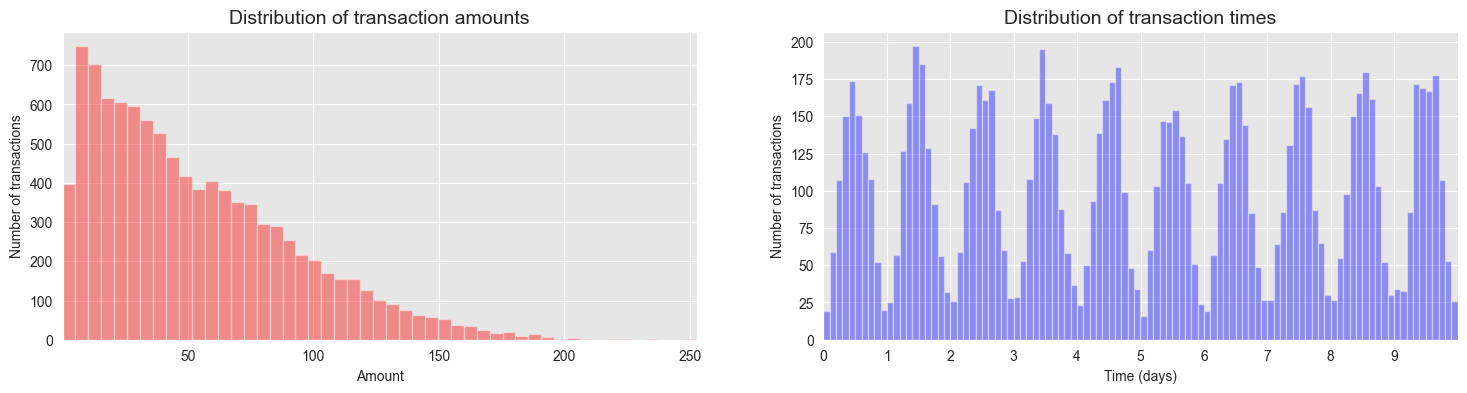

In [20]:
distribution_amount_times_fig

In [22]:
%time transactions_1 = add_frauds(customer_profiles_1, terminal_profiles_1, transactions_1)

Number of frauds from scenario 1: 174
Number of frauds from scenario 2: 76738
Number of frauds from scenario 2: 76738
Number of frauds from scenario 3: 3568
CPU times: user 8.07 s, sys: 31.7 ms, total: 8.1 s
Wall time: 8.13 s
Number of frauds from scenario 3: 3568
CPU times: user 8.07 s, sys: 31.7 ms, total: 8.1 s
Wall time: 8.13 s


In [23]:
transactions_1.TX_FRAUD.mean()

0.23937633660215285

In [24]:
transactions_1.TX_FRAUD.sum()

80480

In [29]:
(nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)=get_stats(transactions_1)

n_days=len(nb_tx_per_day)
tx_stats=pd.DataFrame({"value":pd.concat([nb_tx_per_day/50,nb_fraud_per_day,nb_fraudcard_per_day])})
tx_stats['stat_type']=["nb_tx_per_day"]*n_days+["nb_fraud_per_day"]*n_days+["nb_fraudcard_per_day"]*n_days
tx_stats=tx_stats.reset_index()

In [30]:
%%capture

sns.set(style='darkgrid')
sns.set(font_scale=1.4)

fraud_and_transactions_stats_fig = plt.gcf()

fraud_and_transactions_stats_fig.set_size_inches(15, 8)

sns_plot = sns.lineplot(x="TX_TIME_DAYS", y="value", data=tx_stats, hue="stat_type", hue_order=["nb_tx_per_day","nb_fraud_per_day","nb_fraudcard_per_day"], legend=False)

sns_plot.set_title('Total transactions, and number of fraudulent transactions \n and number of compromised cards per day', fontsize=20)
sns_plot.set(xlabel = "Number of days since beginning of data generation", ylabel="Number")

sns_plot.set_ylim([0,300])

labels_legend = ["# transactions per day (/50)", "# fraudulent txs per day", "# fraudulent cards per day"]

sns_plot.legend(loc='upper left', labels=labels_legend,bbox_to_anchor=(1.05, 1), fontsize=15)

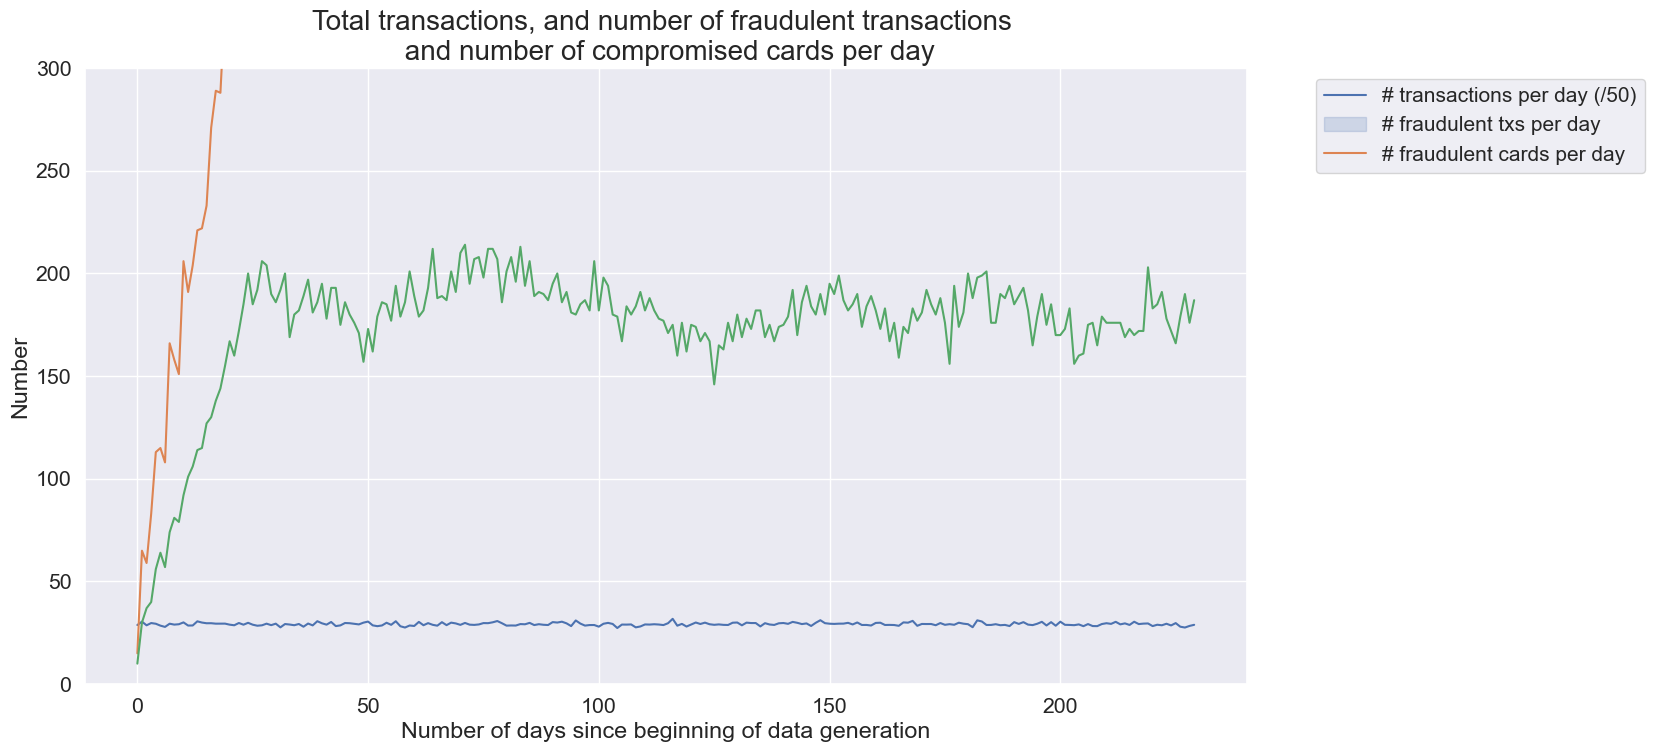

In [31]:
fraud_and_transactions_stats_fig

### Dataset 2: ≥ 100 MB
**Parameters:**
- `n_customers = 1000`
- `n_terminals = 200`
- `nb_days = 460` (approximately 15 months)
- Expected transactions: ~920,000
- Expected size: ~100-110 MB

In [13]:
# Generate Dataset 2 (≥ 100 MB)
(customer_profiles_2, terminal_profiles_2, transactions_2) = \
    generate_dataset(n_customers=1000, 
                     n_terminals=200, 
                     nb_days=460, 
                     start_date="2025-01-01", 
                     r=5)

print(f"\nDataset 2 - Number of transactions: {len(transactions_2)}")
print(f"Dataset 2 - Memory usage: {transactions_2.memory_usage(deep=True).sum() / (1024 * 1024):.2f} MB")

Time to generate customer profiles table: 0.0038s
Time to generate terminal profiles table: 0.0004s
Time to associate terminals to customers: 0.073s


/var/folders/49/2vtyfv4n7cxb_hl_7_5wf97w0000gn/T/ipykernel_6253/3026114656.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], start_date=start_date, nb_days=nb_days)).reset_index(drop=True)
/var/folders/49/2vtyfv4n7cxb_hl_7_5wf97w0000gn/T/ipykernel_6253/3026114656.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transactions_df=custo

Time to generate transactions: 1.3e+01s

Dataset 2 - Number of transactions: 671834
Dataset 2 - Memory usage: 107.64 MB


In [32]:
%time transactions_2 = add_frauds(customer_profiles_2, terminal_profiles_2, transactions_2) 

Number of frauds from scenario 1: 342
Number of frauds from scenario 2: 159185
Number of frauds from scenario 2: 159185
Number of frauds from scenario 3: 7154
CPU times: user 33 s, sys: 106 ms, total: 33.1 s
Wall time: 33.2 s
Number of frauds from scenario 3: 7154
CPU times: user 33 s, sys: 106 ms, total: 33.1 s
Wall time: 33.2 s


### Dataset 3: ≥ 200 MB
**Parameters:**
- `n_customers = 1000`
- `n_terminals = 200`
- `nb_days = 920` (approximately 2.5 years)
- Expected transactions: ~1,840,000
- Expected size: ~200-220 MB

In [14]:
# Generate Dataset 3 (≥ 200 MB)
(customer_profiles_3, terminal_profiles_3, transactions_3) = \
    generate_dataset(n_customers=1000, 
                     n_terminals=200, 
                     nb_days=920, 
                     start_date="2025-01-01", 
                     r=5)

print(f"\nDataset 3 - Number of transactions: {len(transactions_3)}")
print(f"Dataset 3 - Memory usage: {transactions_3.memory_usage(deep=True).sum() / (1024 * 1024):.2f} MB")

Time to generate customer profiles table: 0.005s
Time to generate terminal profiles table: 0.00062s
Time to associate terminals to customers: 0.078s


/var/folders/49/2vtyfv4n7cxb_hl_7_5wf97w0000gn/T/ipykernel_6253/3026114656.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], start_date=start_date, nb_days=nb_days)).reset_index(drop=True)
/var/folders/49/2vtyfv4n7cxb_hl_7_5wf97w0000gn/T/ipykernel_6253/3026114656.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transactions_df=custo

Time to generate transactions: 2.6e+01s

Dataset 3 - Number of transactions: 1343459
Dataset 3 - Memory usage: 215.25 MB
Dataset 3 - Memory usage: 215.25 MB


In [33]:
%time transactions_3 = add_frauds(customer_profiles_3, terminal_profiles_3, transactions_3)

Number of frauds from scenario 1: 728
Number of frauds from scenario 2: 320888
Number of frauds from scenario 2: 320888
Number of frauds from scenario 3: 14436
CPU times: user 2min 14s, sys: 367 ms, total: 2min 15s
Wall time: 2min 15s
Number of frauds from scenario 3: 14436
CPU times: user 2min 14s, sys: 367 ms, total: 2min 15s
Wall time: 2min 15s
